┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


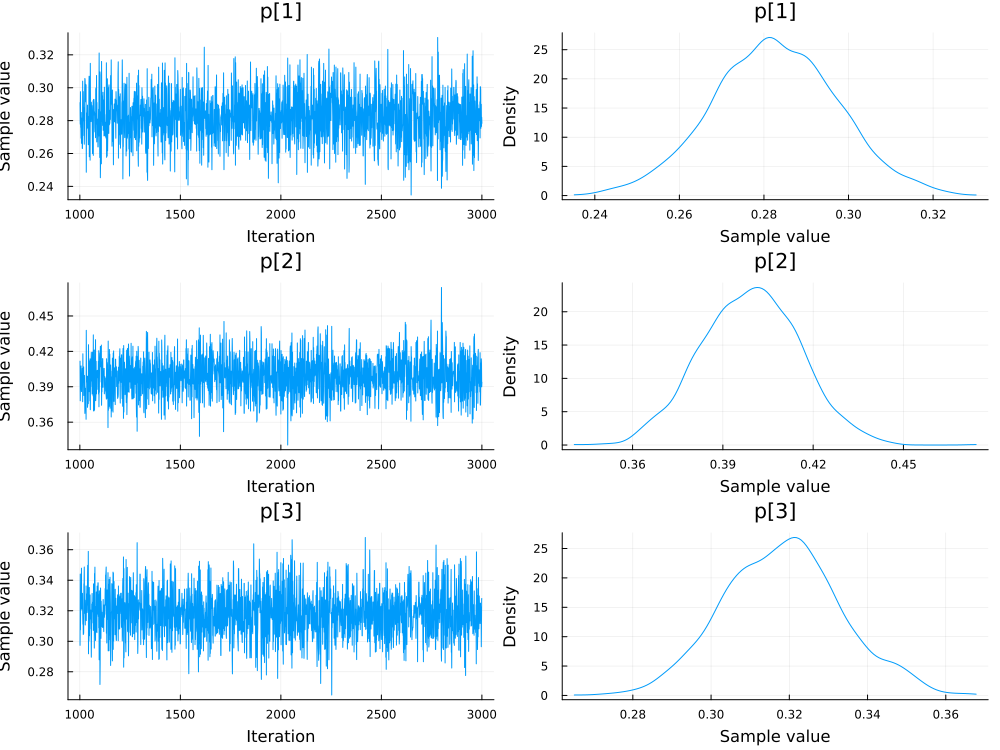

In [21]:
using Turing
using StatsPlots
using Random

# 独自の確率密度関数（例: 三角形分布のような形）
function custom_logpdf(p)
    # 確率パラメータの制約: 0 <= p[i] <= 1, ∑p = 1
    if any(x -> x < 0 || x > 1, p) || abs(sum(p) - 1) > 1e-6
        return -Inf  # 非許容な確率の場合
    end
    # 独自のPDF（例: 特定の重み付けを持つ単純な三角形分布）
    return log(p[1] * 2 + p[2] * 3 + p[3] * 5) - log(10)  # 正規化
end

@model function custom_model(data)
    # パラメータの事前分布をサンプリング
    p ~ Dirichlet(ones(3))  # 初期はDirichletを使用（柔軟な事前分布）

    # 独自の確率密度関数に基づく調整
    Turing.@addlogprob! custom_logpdf(p)  # 手動で確率を加算

    # 観測データの尤度
    data .~ Categorical(p)
end

# サンプルデータの生成
Random.seed!(42)
true_p = [0.3, 0.4, 0.3]
data = rand(Categorical(true_p), 1000)

# モデルを実行
model = custom_model(data)
chain = sample(model, NUTS(), 2000)

# 結果の可視化
plot(chain)


┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


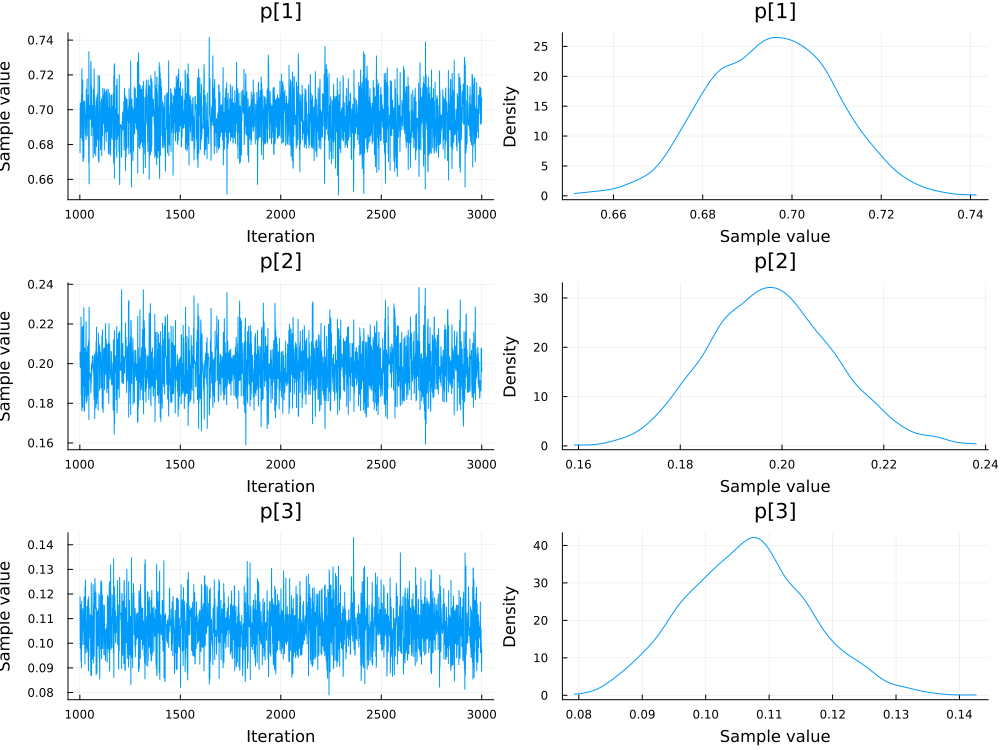

In [22]:
using Turing
using StatsPlots
using Random
using Distributions

# 自作の確率密度関数
function custom_logpdf(p)
    # 確率パラメータの制約: 0 <= p[i] <= 1, ∑p = 1
    if any(x -> x < 0 || x > 1, p) || abs(sum(p) - 1) > 1e-6
        return -Inf  # 非許容な確率の場合
    end

    # 2つのピークを持つ分布: ピーク1とピーク2への距離を計算
    peak1 = [0.7, 0.2, 0.1]
    peak2 = [0.1, 0.2, 0.7]

    # ピークへの距離の二乗和（ユークリッド距離の平方）を使う
    dist1 = sum((p .- peak1).^2)
    dist2 = sum((p .- peak2).^2)

    # ピーク周辺で尤度が高くなるようにする (正規分布に基づく尤度)
    sigma = 0.05  # 尤度の広がりを制御
    loglik1 = logpdf(Normal(0, sigma), sqrt(dist1))
    loglik2 = logpdf(Normal(0, sigma), sqrt(dist2))

    # 2つのピークの尤度を加算（対数空間なので log-sum-exp を利用）
    return log(exp(loglik1) + exp(loglik2))
end

# Turingモデルの定義
@model function custom_model(data)
    # 確率ベクトル p: Dirichlet分布を事前分布としてサンプリング
    p ~ Dirichlet(ones(3))  # 均等な事前分布

    # 自作の確率密度関数に基づく尤度の調整
    Turing.@addlogprob! custom_logpdf(p)

    # 観測データの尤度: カテゴリカル分布を使用
    data .~ Categorical(p)
end

# サンプルデータの生成
Random.seed!(42)
true_p = [0.7, 0.2, 0.1]  # 真の確率ベクトル (ピーク1)
data = rand(Categorical(true_p), 1000)

# モデルを実行
model = custom_model(data)
chain = sample(model, NUTS(), 2000)

# 結果の可視化
plot(chain)


┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


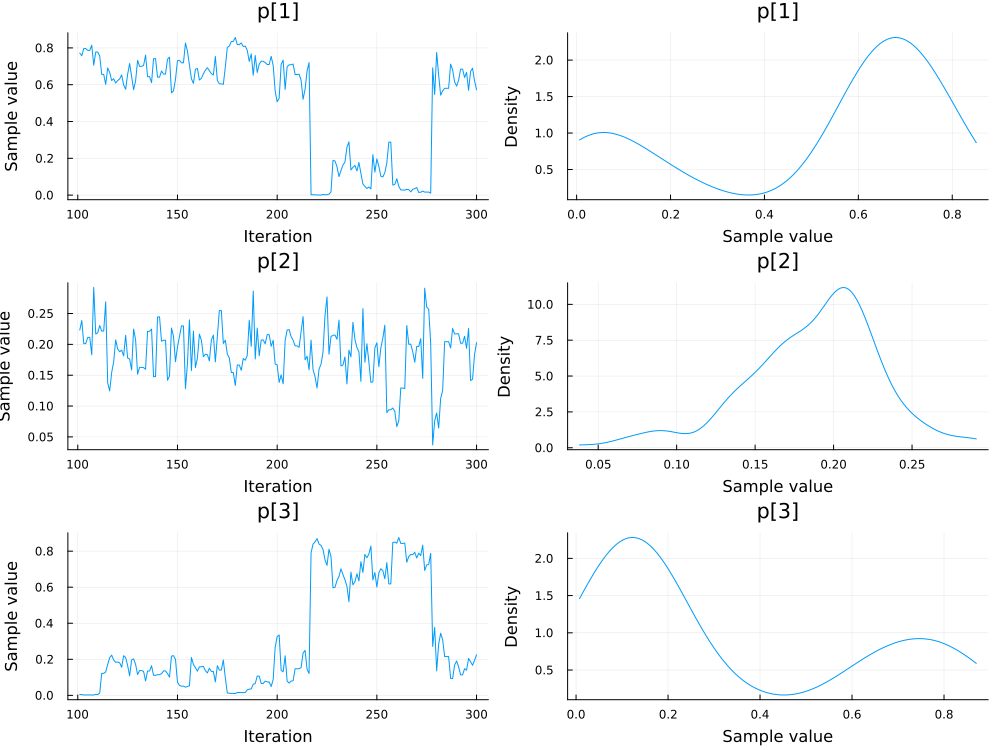

In [29]:
using Distributions
using StatsPlots
using Random
using KernelDensity
using Turing

# 1. 二峰性のデータを生成
function generate_bimodal_data(n_samples)
    Random.seed!(42)

    # 二つのピークからどちらを選ぶかをランダムに決定
    peak1 = [0.7, 0.2, 0.1]
    peak2 = [0.1, 0.2, 0.7]

    data = Vector{Vector{Float64}}()
    for _ in 1:n_samples
        # 50%の確率で各ピークを選択
        peak = rand() < 0.5 ? peak1 : peak2
        # ピークの周りにノイズを加える
        noisy_sample = peak .+ rand(Normal(0, 0.05), 3)
        # 正規化して確率の合計が1になるようにする
        normalized = noisy_sample ./ sum(noisy_sample)
        push!(data, normalized)
    end
    return data
end

# 2. KDEを使用して確率密度を推定
function estimate_density(data)
    # 3次元データそれぞれに対してKDEを適用
    kdes = [kde([d[i] for d in data]) for i in 1:3]

    # 推定された密度関数を返す
    function estimated_logpdf(p)
        # 確率の制約チェック
        if any(x -> x < 0 || x > 1, p) || abs(sum(p) - 1) > 1e-6
            return -Inf
        end
        # 各次元での対数確率密度の合計
        return sum(log(pdf(kdes[i], p[i])) for i in 1:3)
    end

    return estimated_logpdf
end

# 3. Turingモデルの定義
@model function density_model(estimated_logpdf)
    # 事前分布
    p ~ Dirichlet(ones(3))

    # 推定された確率密度関数を使用
    Turing.@addlogprob! estimated_logpdf(p)
end

# メインの処理
# データ生成
n_samples = 100
data = generate_bimodal_data(n_samples)

# 確率密度関数の推定
estimated_logpdf = estimate_density(data)

# モデルの実行
model = density_model(estimated_logpdf)
chain = sample(model, NUTS(), 200)

# 結果の可視化
plot(chain)

In [24]:
# 推定結果の要約
println("推定された確率パラメータの平均値:")
println(mean(chain))

推定された確率パラメータの平均値:
Mean (3 x 2)


In [25]:
using Distributions
using StatsPlots
using Random
using Turing

# 1. 二峰性のデータ生成
function generate_bimodal_data(n_samples)
    Random.seed!(42)

    # 二つのピーク
    peak1 = [0.7, 0.2, 0.1]
    peak2 = [0.1, 0.2, 0.7]

    data = Vector{Vector{Float64}}()
    for _ in 1:n_samples
        # 50%の確率でピークを選択
        peak = rand(Bernoulli(0.5)) == 1 ? peak1 : peak2
        # ノイズを加えて正規化
        noisy_sample = peak .+ rand(Normal(0, 0.05), 3)
        normalized = noisy_sample ./ sum(noisy_sample)
        push!(data, normalized)
    end
    return data
end

# 2. 混合ガウス分布 (GMM) を用いた密度関数
function fit_gmm_density(data)
    # 3次元データを行列に変換
    data_matrix = reduce(hcat, data)'

    # 混合ガウス分布の推定 (2成分)
    gmm = fit(MixtureModel, data_matrix, 2)

    # 尤度関数を返す
    function estimated_logpdf(p)
        # 確率の制約チェック
        if any(x -> x < 0 || x > 1, p) || abs(sum(p) - 1) > 1e-6
            return -Inf
        end
        return log(pdf(gmm, p))
    end

    return estimated_logpdf
end

# 3. Turingモデル
@model function gmm_density_model(estimated_logpdf)
    # 事前分布 (Dirichlet)
    p ~ Dirichlet(ones(3))

    # 混合ガウス分布に基づく尤度
    Turing.@addlogprob! estimated_logpdf(p)
end

# 4. メイン処理
# データ生成
n_samples = 1000
data = generate_bimodal_data(n_samples)

# データの可視化
p1_vals = [d[1] for d in data]
p2_vals = [d[2] for d in data]
p3_vals = [d[3] for d in data]

plot(layout=(3, 1), size=(600, 800))
histogram!(p1_vals, bins=50, title="p[1] の分布", alpha=0.5, normalize=:pdf)
histogram!(p2_vals, bins=50, title="p[2] の分布", alpha=0.5, normalize=:pdf)
histogram!(p3_vals, bins=50, title="p[3] の分布", alpha=0.5, normalize=:pdf)

# GMMで確率密度関数を推定
estimated_logpdf = fit_gmm_density(data)

# Turing.jlによるモデル推論
model = gmm_density_model(estimated_logpdf)
chain = sample(model, NUTS(), 2000)

# 結果の可視化
plot(chain)


LoadError: MethodError: no method matching fit_mle(::Type{MixtureModel}, ::LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, ::Int64)
The function `fit_mle` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  fit_mle([91m::Type{DiscreteUniform}[39m, ::AbstractArray{<:Real})
[0m[90m   @[39m [32mDistributions[39m [90m~/.julia/packages/Distributions/Qeo2J/src/univariate/discrete/[39m[90m[4mdiscreteuniform.jl:111[24m[39m
[0m  fit_mle([91m::Type{IsoNormal}[39m, ::AbstractMatrix{Float64}, [91m::AbstractVector[39m)
[0m[90m   @[39m [32mDistributions[39m [90m~/.julia/packages/Distributions/Qeo2J/src/multivariate/[39m[90m[4mmvnormal.jl:498[24m[39m
[0m  fit_mle([91m::Type{IsoNormal}[39m, ::AbstractMatrix{Float64})
[0m[90m   @[39m [32mDistributions[39m [90m~/.julia/packages/Distributions/Qeo2J/src/multivariate/[39m[90m[4mmvnormal.jl:482[24m[39m
[0m  ...
